In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import cv2

import numpy as np

import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Models

In [2]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, num_layers, **kwargs):
    super(ConvBlock, self).__init__()

    channels = [in_channels] + [out_channels for i in range(num_layers)]
    layers = []

    for i in range(num_layers):
      layer = nn.Sequential(
          nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], **kwargs),
          nn.BatchNorm2d(channels[i+1]),
          nn.ReLU()
      )
      layers.append(layer)

    self.conv = nn.Sequential(*layers)

  def forward(self, x):
    return self.conv(x)

In [3]:
class AttentionBlock(nn.Module):
  def __init__(self, in_features_l, in_features_g, attn_features, scale_factor, normalize_attn=True):
    super(AttentionBlock, self).__init__()
    self.scale_factor = scale_factor
    self.normalize_attn = normalize_attn

    self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, stride=1, padding=0, bias=False)
    self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, stride=1, padding=0, bias=False)
    self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

  def forward(self, l, g):
    N, C, H, W = l.size()
    l_ = self.W_l(l)
    g_ = self.W_g(g)

    if self.scale_factor > 1:
      g_ = F.interpolate(g_, scale_factor=self.scale_factor, mode='bilinear', align_corners=False)

    c = self.phi(F.relu(l_ + g_))

    if self.normalize_attn:
      a = F.softmax(c.view(N,1,-1), dim=2).view(N, 1, W, H)
    else:
      a = torch.sigmoid(c)


    f = torch.matmul(a.expand_as(l), l)

    if self.normalize_attn:
      f = f.view(N, C, -1).sum(dim=2)
    else:
      f = F.adaptive_avg_pool2d(f, (1, 1)).view(N, C)

    return a, f

In [4]:
class VGG_Attn(nn.Module):
  def __init__(self, num_classes=10, attention=True, normalize_attn=False):
    super(VGG_Attn, self).__init__()
    self.attention = attention

    self.conv1 = ConvBlock(in_channels=3, out_channels=64, num_layers=2, kernel_size=3, stride=1, padding=1)

    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = ConvBlock(in_channels=64, out_channels=128, num_layers=2, kernel_size=3, stride=1, padding=1)

    self.conv3 = ConvBlock(in_channels=128, out_channels=256, num_layers=3, kernel_size=3, stride=1, padding=1)

    self.conv4 = ConvBlock(in_channels=256, out_channels=512, num_layers=3, kernel_size=3, stride=1, padding=1)

    self.conv5 = ConvBlock(in_channels=512, out_channels=512, num_layers=3, kernel_size=3, stride=1, padding=1)

    self.attn1 = AttentionBlock(256, 512, 256, 8, normalize_attn=normalize_attn)
    self.attn2 = AttentionBlock(512, 512, 256, 4, normalize_attn=normalize_attn)

    self.avgpool = nn.AvgPool2d(7, stride=1)

    if self.attention:
      self.fc_attn = nn.Linear(in_features=512+512+256, out_features=num_classes)
    else:
      features = [512*7*7, 4096, 4096, num_classes]
      layers = []

      for i in range(3):
        if i!=2:
          layer = nn.Sequential(
              nn.Dropout(0.5),
              nn.Linear(features[i], features[i+1]),
              nn.ReLU()
          )
        else:
          layer = nn.Sequential(
              nn.Dropout(0.5),
              nn.Linear(features[i], features[i+1]),
          )
        layers.append(layer)

      self.fc = nn.Sequential(*layers)


  def forward(self, x):
    block1 = self.conv1(x)
    pool1 = self.maxpool(block1)

    block2 = self.conv2(pool1)
    pool2 = self.maxpool(block2)

    block3 = self.conv3(pool2)
    pool3 = self.maxpool(block3)

    block4 = self.conv4(pool3)
    pool4 = self.maxpool(block4)

    block5 = self.conv5(pool4)
    pool5 = self.maxpool(block5)

    if self.attention:
      N, C, H, W = pool5.size()

      a1, g1 = self.attn1(block3, pool5)
      a2, g2 = self.attn2(block4, pool5)
      g = self.avgpool(pool5).view(N, 512)

      g_cap = torch.cat((g1, g2, g), dim=1)
      out = self.fc_attn(g_cap)
      if self.training:
        return out
      else:
        return out, a1, a2

    else:
      out = self.fc(pool5.reshape(pool5.size(0), -1))
      return out

## Data

In [5]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

train_set = torchvision.datasets.CIFAR10(root='../data',
                                         train=True,
                                         download=True,
                                         transform=transforms.Compose([
                                            transforms.Resize((224, 224)),
                                            transforms.ToTensor(),
                                            normalize
                                         ]))
test_set = torchvision.datasets.CIFAR10(root='../data',
                                        train=False,
                                        download=True,
                                        transform=transforms.Compose([
                                            transforms.Resize((224, 224)),
                                            transforms.ToTensor(),
                                            normalize
                                         ]))

100%|██████████| 170498071/170498071 [00:04<00:00, 34424240.64it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [6]:
names = {}
names[0] = 'airplane'
names[1] = 'automobile'
names[2] = 'bird'
names[3] = 'cat'
names[4] = 'deer'
names[5] = 'dog'
names[6] = 'frog'
names[7] = 'horse'
names[8] = 'ship'
names[9] = 'truck'

In [7]:
BATCH_SIZE = 64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

## Utils

In [8]:
def accuracy(y_pred, y_true):
  y_pred, y_true = y_pred.to(device), y_true.to(device)
  acc = torch.sum(y_pred.argmax(dim=1) == y_true).item() / len(y_pred) * 100
  return acc

In [9]:
def train_step(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):

  model.to(device)
  model.train()
  train_loss = 0
  train_acc = 0

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy(y_pred=y_pred,
                          y_true=y)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f'Train Loss = {train_loss:.5f} | Train accuracy = {train_acc:.2f}%')

  return train_loss, train_acc

In [10]:
def test_step(model: torch.nn.Module,
               test_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device):

  test_loss = 0
  test_acc = 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
      X, y = X.to(device), y.to(device)

      if model.attention:
        y_pred,_, _ = model(X)
      else:
        y_pred = model(X)

      loss = loss_fn(y_pred, y)

      test_loss += loss
      test_acc += accuracy(y_pred=y_pred,
                           y_true=y)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    print(f'Test Loss = {test_loss:.5f} | Test accuracy = {test_acc:.2f}%')

    return test_loss, test_acc

In [11]:
def visualize_attn(images, a, scale_factor, nrow=8, ratio=0.3, attention=True):
  imgs = torchvision.utils.make_grid((images), nrow=nrow, padding=2)
  imgs = imgs.permute(1, 2, 0).cpu().numpy()

  attn = F.interpolate(a, scale_factor=scale_factor, mode='bilinear', align_corners=False)
  attn = torchvision.utils.make_grid(attn, nrow=nrow, normalize=True, scale_each=True)
  attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
  attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
  attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
  attn = np.float32(attn) / 255

  if attention:
    visualization = ratio*attn + (1-ratio)*imgs
    return visualization
  else:
    return imgs

In [12]:
class Metric:
  def __init__(self):
    self.values = []
    self.epochs = []

  def update(self, value, epoch):
    self.values.append(value)
    self.epochs.append(epoch)

In [73]:
def plot(epoch_list, vals_attn, vals, y_label):

  if type(vals_attn[0]) == torch.Tensor:
    for i in range(len(vals_attn)):
      vals_attn[i] = vals_attn[i].to('cpu').detach().numpy()
      vals[i] = vals[i].to('cpu').detach().numpy()

  plt.figure(figsize=(5, 4))
  plt.plot(epoch_list, vals_attn, color='r', label='With Attention')
  plt.plot(epoch_list, vals, color='g', label='Without Attention')
  title = y_label + ' vs Epochs'
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel(y_label)
  plt.legend()

## Training

In [14]:
num_classes = 10
epochs = 10
learning_rate = 0.01

vgg_attn = VGG_Attn(num_classes).to(device)
vgg = VGG_Attn(num_classes, attention=False).to(device)


# Loss and optimizer for with attention
criterion_attn = nn.CrossEntropyLoss()
optimizer_attn = torch.optim.SGD(vgg_attn.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

# Loss and optimizer for without attention
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [82]:
total_params_vgg = sum(p.numel() for p in vgg.parameters())
print(f"Number of parameters: {total_params_vgg}")

Number of parameters: 134769228


In [83]:
total_params_vgg_attn = sum(p.numel() for p in vgg_attn.parameters())
print(f"Number of parameters: {total_params_vgg_attn}")

Number of parameters: 15195212


### Training VGG_attn

In [19]:
train_losses_attn = Metric()
train_accs_attn = Metric()
test_losses_attn = Metric()
test_accs_attn = Metric()

start_time = time.time()
for epoch in range(1, epochs+1):
  print(f'\nEpoch: {epoch}\n-------')
  train_loss, train_acc = train_step(model=vgg_attn,
                                     train_dataloader=train_loader,
                                     loss_fn=criterion_attn,
                                     optimizer=optimizer_attn,
                                     device=device)

  train_losses_attn.update(train_loss, epoch)
  train_accs_attn.update(train_acc, epoch)

  test_loss, test_acc = test_step(model=vgg_attn,
                                  test_dataloader=test_loader,
                                  loss_fn=criterion_attn,
                                  device=device)

  test_losses_attn.update(test_loss, epoch)
  test_accs_attn.update(test_acc, epoch)

  print('-------------')
end_time = time.time()
vgg_attn_time = end_time - start_time
print(f'\nTime to train VGG_Attn on {device} is {vgg_attn_time}s')


Epoch: 1
-------
Train Loss = 1.77040 | Train accuracy = 34.50%
Test Loss = 1.43430 | Test accuracy = 45.30%
-------------

Epoch: 2
-------
Train Loss = 1.21070 | Train accuracy = 55.99%
Test Loss = 1.32165 | Test accuracy = 51.50%
-------------

Epoch: 3
-------
Train Loss = 0.94652 | Train accuracy = 66.29%
Test Loss = 0.94093 | Test accuracy = 67.92%
-------------

Epoch: 4
-------
Train Loss = 0.79429 | Train accuracy = 72.47%
Test Loss = 0.84676 | Test accuracy = 71.90%
-------------

Epoch: 5
-------
Train Loss = 0.67459 | Train accuracy = 77.23%
Test Loss = 0.88668 | Test accuracy = 69.48%
-------------

Epoch: 6
-------
Train Loss = 0.59150 | Train accuracy = 80.13%
Test Loss = 0.71197 | Test accuracy = 76.27%
-------------

Epoch: 7
-------
Train Loss = 0.53374 | Train accuracy = 82.21%
Test Loss = 0.73778 | Test accuracy = 74.58%
-------------

Epoch: 8
-------
Train Loss = 0.48604 | Train accuracy = 84.28%
Test Loss = 0.73777 | Test accuracy = 74.79%
-------------

Epoch: 

### Training VGG16

In [20]:
train_losses = Metric()
train_accs = Metric()
test_losses = Metric()
test_accs = Metric()

start_time = time.time()
for epoch in range(1, epochs+1):
  print(f'\nEpoch: {epoch}\n-------')
  train_loss, train_acc = train_step(model=vgg,
                                     train_dataloader=train_loader,
                                     loss_fn=criterion,
                                     optimizer=optimizer,
                                     device=device)

  train_losses.update(train_loss, epoch)
  train_accs.update(train_acc, epoch)

  test_loss, test_acc = test_step(model=vgg,
                                  test_dataloader=test_loader,
                                  loss_fn=criterion,
                                  device=device)

  test_losses.update(test_loss, epoch)
  test_accs.update(test_acc, epoch)

  print('-------------')
end_time = time.time()
vgg_time = end_time - start_time
print(f'\nTime to train VGG16 on {device} is {vgg_time}s')


Epoch: 1
-------
Train Loss = 1.73146 | Train accuracy = 36.64%
Test Loss = 1.48528 | Test accuracy = 46.73%
-------------

Epoch: 2
-------
Train Loss = 1.18684 | Train accuracy = 57.65%
Test Loss = 1.01089 | Test accuracy = 64.81%
-------------

Epoch: 3
-------
Train Loss = 0.92240 | Train accuracy = 67.88%
Test Loss = 0.81124 | Test accuracy = 72.15%
-------------

Epoch: 4
-------
Train Loss = 0.77748 | Train accuracy = 73.13%
Test Loss = 0.73325 | Test accuracy = 74.36%
-------------

Epoch: 5
-------
Train Loss = 0.68090 | Train accuracy = 76.51%
Test Loss = 0.74062 | Test accuracy = 74.46%
-------------

Epoch: 6
-------
Train Loss = 0.62004 | Train accuracy = 78.78%
Test Loss = 0.76117 | Test accuracy = 73.90%
-------------

Epoch: 7
-------
Train Loss = 0.57027 | Train accuracy = 80.58%
Test Loss = 0.69476 | Test accuracy = 75.82%
-------------

Epoch: 8
-------
Train Loss = 0.53685 | Train accuracy = 81.79%
Test Loss = 0.78047 | Test accuracy = 73.50%
-------------

Epoch: 

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
PATH = '/content/drive/MyDrive/Projects/VGG Attention'
PATH += '/vgg_attn.pth'
torch.save(vgg_attn, PATH)

In [30]:
PATH = '/content/drive/MyDrive/Projects/VGG Attention'
PATH += '/vgg16.pth'
torch.save(vgg, PATH)

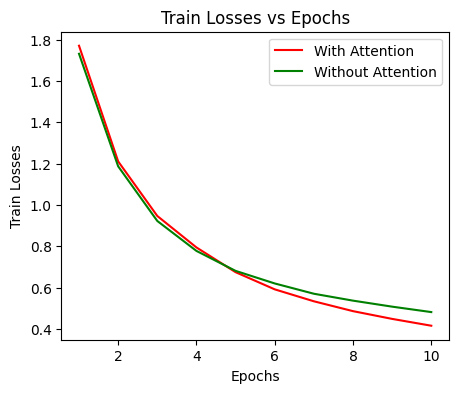

In [70]:
plot(train_losses_attn.epochs, train_losses_attn.values, train_losses.values, 'Train Losses')

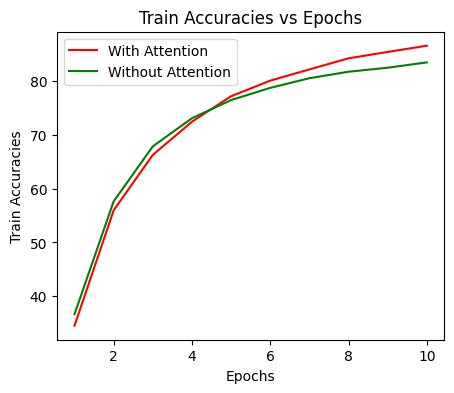

In [71]:
plot(train_accs_attn.epochs, train_accs_attn.values, train_accs.values, 'Train Accuracies')

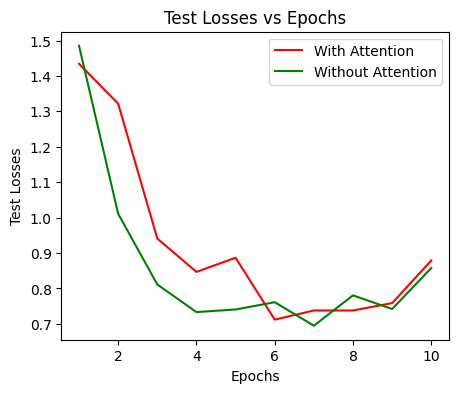

In [74]:
plot(test_losses_attn.epochs, test_losses_attn.values, test_losses.values, 'Test Losses')

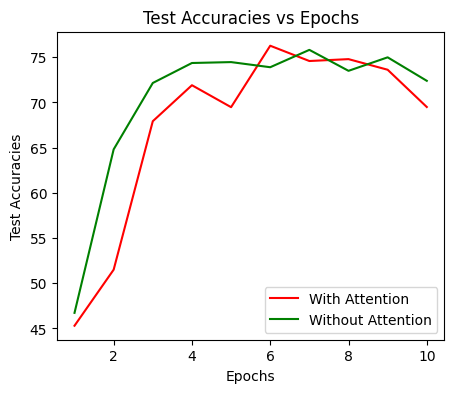

In [75]:
plot(test_accs_attn.epochs, test_accs_attn.values, test_accs.values, 'Test Accuracies')

Text(0.5, 1.0, 'Parameter Count')

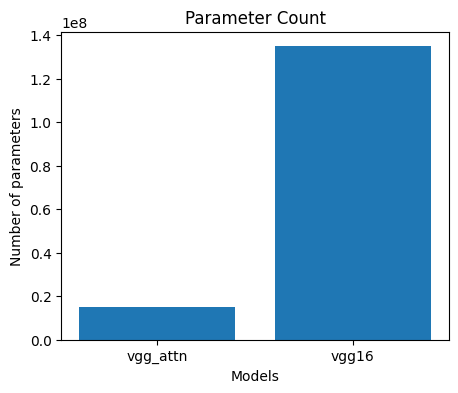

In [86]:
X = ['vgg_attn', 'vgg16']
Y = [total_params_vgg_attn, total_params_vgg]

plt.figure(figsize=(5, 4))
plt.bar(X, Y)
plt.xlabel('Models')
plt.ylabel('Number of parameters')
plt.title('Parameter Count')

## Inference

In [76]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

In [77]:
for images, _ in train_loader:
  train_images = images
  print(train_images.shape)
  break

train_images = train_images.to(device)

for images, _ in test_loader:
  test_images = images
  print(test_images.shape)
  break
test_images = test_images.to(device)

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


In [78]:
_, a1, a2 = vgg_attn(train_images)

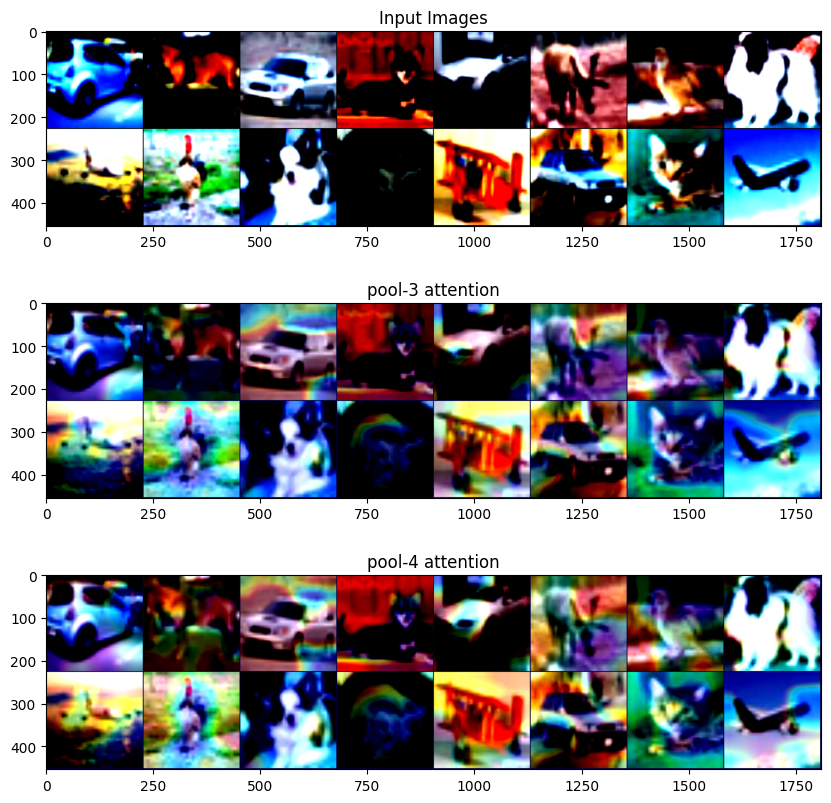

In [79]:
orig = visualize_attn(train_images, a1, 4, attention=False)
first = visualize_attn(train_images, a1, 4, ratio=0.5, attention=True)
second = visualize_attn(train_images, a2, 8, ratio=0.5, attention=True)

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(10, 10))
ax1.imshow(orig)
ax2.imshow(first)
ax3.imshow(second)
ax1.title.set_text('Input Images')
ax2.title.set_text('pool-3 attention')
ax3.title.set_text('pool-4 attention')

In [80]:
_, a1, a2 = vgg_attn(test_images)

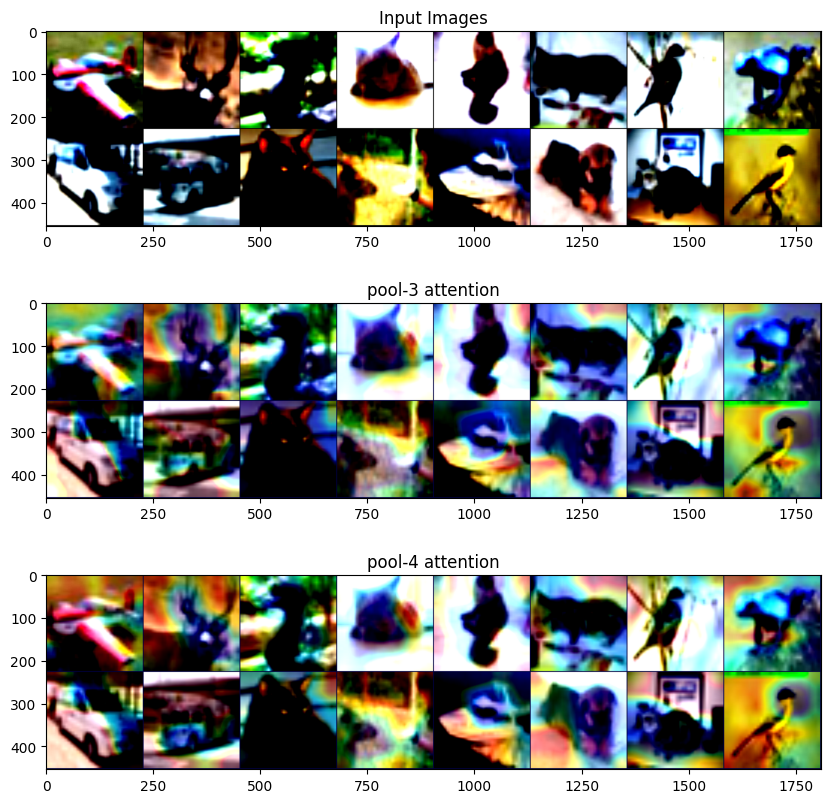

In [81]:
orig = visualize_attn(test_images, a1, 4, attention=False)
first = visualize_attn(test_images, a1, 4, ratio=0.5, attention=True)
second = visualize_attn(test_images, a2, 8, ratio=0.5, attention=True)

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(10, 10))
ax1.imshow(orig)
ax2.imshow(first)
ax3.imshow(second)
ax1.title.set_text('Input Images')
ax2.title.set_text('pool-3 attention')
ax3.title.set_text('pool-4 attention')